# **Convolutional Conditional Variational Autoencoder**

## **Libraries**

In [14]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch
import time

In [2]:
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## **Settings**

In [3]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print('Device:', device)

Device: cpu


In [15]:
random_seed = 0
learning_rate = 0.001
num_epochs = 10
batch_size = 128

In [5]:
num_classes = 10
num_features = 784
num_latent = 50

## **MNIST dataset**

In [6]:
train_dataset = datasets.MNIST(root='data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='data', train=False, transform=transforms.ToTensor())

In [7]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


## **Model**

In [9]:
def to_onehot(labels, num_classes, device):

    labels_onehot = torch.zeros(labels.size()[0], num_classes).to(device)
    labels_onehot.scatter_(1, labels.view(-1, 1), 1)

    return labels_onehot

In [10]:
class ConditionalVariationalAutoencoder(torch.nn.Module):
    def __init__(self, num_features, num_latent, num_classes):
        super(ConditionalVariationalAutoencoder, self).__init__()
        self.num_classes = num_classes

        self.enc_conv_1 = torch.nn.Conv2d(in_channels=1+self.num_classes,
                                          out_channels=16,
                                          kernel_size=(6, 6),
                                          stride=(2, 2),
                                          padding=0)

        self.enc_conv_2 = torch.nn.Conv2d(in_channels=16,
                                          out_channels=32,
                                          kernel_size=(4, 4),
                                          stride=(2, 2),
                                          padding=0)                 
        
        self.enc_conv_3 = torch.nn.Conv2d(in_channels=32,
                                          out_channels=64,
                                          kernel_size=(2, 2),
                                          stride=(2, 2),
                                          padding=0)                     
        
        self.z_mean = torch.nn.Linear(64*2*2, num_latent)
        self.z_log_var = torch.nn.Linear(64*2*2, num_latent)
        
        self.dec_linear_1 = torch.nn.Linear(num_latent+self.num_classes, 64*2*2)
               
        self.dec_deconv_1 = torch.nn.ConvTranspose2d(in_channels=64,
                                                     out_channels=32,
                                                     kernel_size=(2, 2),
                                                     stride=(2, 2),
                                                     padding=0)
                                 
        self.dec_deconv_2 = torch.nn.ConvTranspose2d(in_channels=32,
                                                     out_channels=16,
                                                     kernel_size=(4, 4),
                                                     stride=(3, 3),
                                                     padding=1)
        
        self.dec_deconv_3 = torch.nn.ConvTranspose2d(in_channels=16,
                                                     out_channels=1,
                                                     kernel_size=(6, 6),
                                                     stride=(3, 3),
                                                     padding=4)        


    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(device)
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def encoder(self, features, targets):
        onehot_targets = to_onehot(targets, self.num_classes, device)
        onehot_targets = onehot_targets.view(-1, self.num_classes, 1, 1)
        
        ones = torch.ones(features.size()[0], 
                          self.num_classes,
                          features.size()[2], 
                          features.size()[3], 
                          dtype=features.dtype).to(device)
        ones = ones * onehot_targets
        x = torch.cat((features, ones), dim=1)
        
        x = self.enc_conv_1(x)
        x = F.leaky_relu(x)
        
        x = self.enc_conv_2(x)
        x = F.leaky_relu(x)
        
        x = self.enc_conv_3(x)
        x = F.leaky_relu(x)
        
        z_mean = self.z_mean(x.view(-1, 64*2*2))
        z_log_var = self.z_log_var(x.view(-1, 64*2*2))
        encoded = self.reparameterize(z_mean, z_log_var)
        return z_mean, z_log_var, encoded
    
    def decoder(self, encoded, targets):
        onehot_targets = to_onehot(targets, self.num_classes, device)
        encoded = torch.cat((encoded, onehot_targets), dim=1)        
        
        x = self.dec_linear_1(encoded)
        x = x.view(-1, 64, 2, 2)
        
        x = self.dec_deconv_1(x)
        x = F.leaky_relu(x)
        
        x = self.dec_deconv_2(x)
        x = F.leaky_relu(x)
        
        x = self.dec_deconv_3(x)
        x = F.leaky_relu(x)
        
        decoded = torch.sigmoid(x)
        return decoded

    def forward(self, features, targets):
        
        z_mean, z_log_var, encoded = self.encoder(features, targets)
        decoded = self.decoder(encoded, targets)
        
        return z_mean, z_log_var, encoded, decoded

In [11]:
torch.manual_seed(random_seed)
model = ConditionalVariationalAutoencoder(num_features, num_latent, num_classes)
model = model.to(device)

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

## **Training**

In [16]:
start_time = time.time()

for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
        targets = targets.to(device)

        z_mean, z_log_var, encoded, decoded = model(features, targets)

        kl_divergence = (0.5 * (z_mean**2 + torch.exp(z_log_var) - z_log_var - 1)).sum()
        
        pixelwise_bce = F.binary_cross_entropy(decoded, features, reduction='sum')
        cost = kl_divergence + pixelwise_bce
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
            
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 000/469 | Cost: 25518.6953
Epoch: 001/010 | Batch 050/469 | Cost: 26175.2031
Epoch: 001/010 | Batch 100/469 | Cost: 24577.8281
Epoch: 001/010 | Batch 150/469 | Cost: 25630.9883
Epoch: 001/010 | Batch 200/469 | Cost: 24991.7871
Epoch: 001/010 | Batch 250/469 | Cost: 24498.3379
Epoch: 001/010 | Batch 300/469 | Cost: 23966.2188
Epoch: 001/010 | Batch 350/469 | Cost: 23882.9961
Epoch: 001/010 | Batch 400/469 | Cost: 23229.0312
Epoch: 001/010 | Batch 450/469 | Cost: 23623.8555
Time elapsed: 0.81 min
Epoch: 002/010 | Batch 000/469 | Cost: 22998.7285
Epoch: 002/010 | Batch 050/469 | Cost: 22776.8086
Epoch: 002/010 | Batch 100/469 | Cost: 21879.7168
Epoch: 002/010 | Batch 150/469 | Cost: 22483.3809
Epoch: 002/010 | Batch 200/469 | Cost: 22026.9863
Epoch: 002/010 | Batch 250/469 | Cost: 21965.6836
Epoch: 002/010 | Batch 300/469 | Cost: 21993.0039
Epoch: 002/010 | Batch 350/469 | Cost: 21832.5762
Epoch: 002/010 | Batch 400/469 | Cost: 21224.0625
Epoch: 002/010 | Batch 450/

## **Evaluation**

In [17]:
n_images = 15
image_width = 28

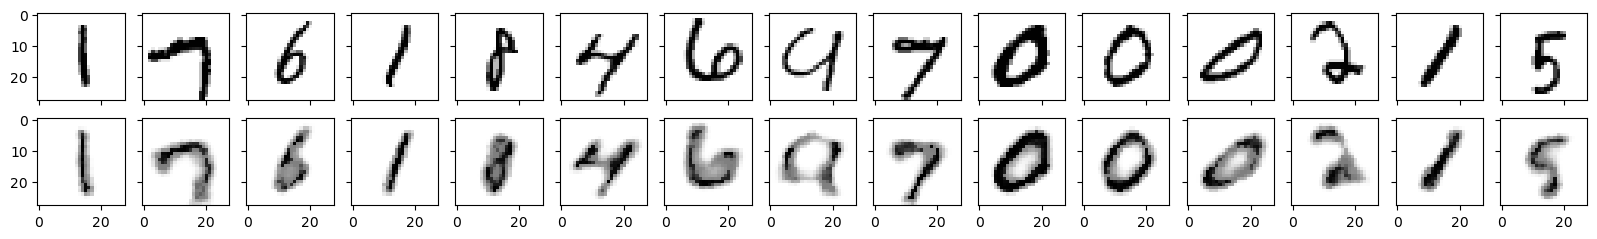

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images, 0]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        cpu_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(cpu_img.view((image_width, image_width)), cmap='binary')

Class Label 0


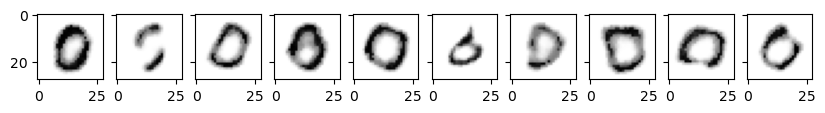

Class Label 1


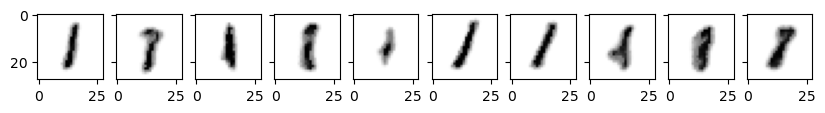

Class Label 2


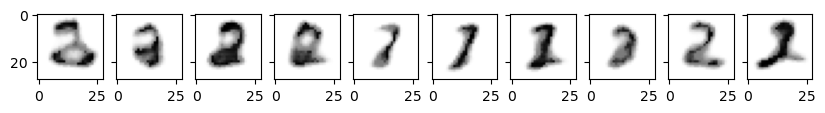

Class Label 3


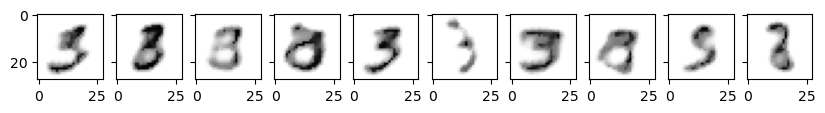

Class Label 4


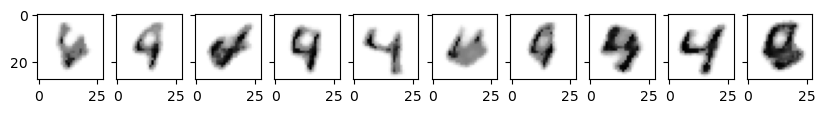

Class Label 5


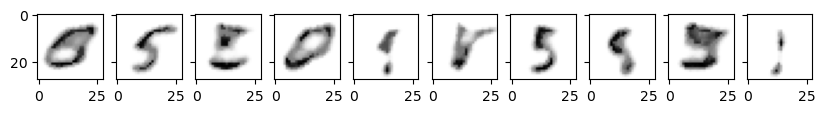

Class Label 6


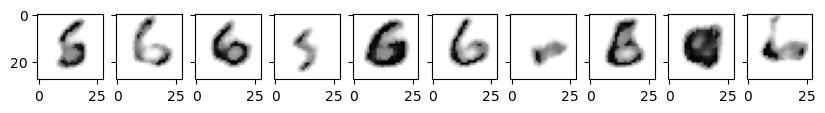

Class Label 7


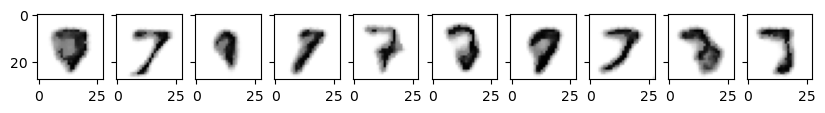

Class Label 8


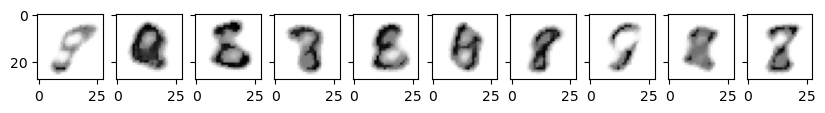

Class Label 9


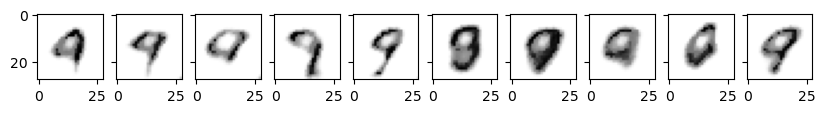

In [19]:
for i in range(10):
    labels = torch.tensor([i]*10).to(device)
    n_images = labels.size()[0]
    rand_features = torch.randn(n_images, num_latent).to(device)
    new_images = model.decoder(rand_features, labels)

    image_width = 28

    fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(10, 2.5), sharey=True)
    decoded_images = new_images[:n_images, 0]

    print('Class Label %d' % i)

    for ax, img in zip(axes, decoded_images):
        cpu_img = img.detach().to(torch.device('cpu'))
        ax.imshow(cpu_img.view((image_width, image_width)), cmap='binary')
        
    plt.show()